<a href="https://colab.research.google.com/github/ihsntgl/bioinformatic/blob/main/protein_protein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Python'da protein etkileşim ağlarını görselleştirme**

Kaynak: https://towardsdatascience.com/visualizing-protein-networks-in-python-58a9b51be9d5

Protein etkileşim verileri inanılmaz derecede önemlidir. Genler tarafından kodlanan biyomoleküller arasındaki etkileşimi tanımlar. Hücresel fonksiyonun karmaşıklığını anlamamıza ve hatta potansiyel terapötikleri tahmin etmemize olanak tanır. Protein etkileşim verilerini içeren birçok veritabanı vardır, ancak STRING en iyilerinden biridir. Bu yazının yazıldığı anda 3.123.056.667 toplam etkileşim barındırıyordu. Bu etkileşimler, 5.000'den fazla organizmada 20.000.000'den fazla proteini oluşturmak için bir araya gelir. Bu makalede, STRING API'sinden protein etkileşim verilerini nasıl indireceğinizi ve NetworkX kullanarak bu verilerin grafiklerini ve görselleştirmelerini nasıl oluşturacağınızı göstereceğim.

**Verilerin Toplanması ve Hazırlanması**

In [1]:
import networkx as nx
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

Veri setimiz, serotonin yollarında yer alan bir avuç protein için ikili etkileşimler içerecektir. Bu etkileşimlerin STRING içinde bulunmasının birkaç yolu vardır. STRING web sitesine bir protein listesiyle gidebilir ve çoklu protein aramasını kullanabiliriz, ancak burada her şeyi Python kullanarak yapmak istiyoruz. İstek kitaplığı, verileri toplamak için HTTP isteklerini kolayca kullanmamızı sağlar. STRING belgeleri, REST API'yi kullanma hakkında ayrıntılar verir ve birçok örneğe sahiptir, ancak birden çok protein için ağ bilgilerini toplamaya yönelik temel çağrı şuna benzer:

Çıktı formatı, tanımlayıcılar ve isteğe bağlı parametrelerle ilgili ayrıntıların tümü belgelerde bulunabilir. tsv (sekmeyle ayrılmış değerler) çıktı biçimini, %0d'lerle ayrılmış protein tanımlayıcılarının bir listesini ve isteğe bağlı bir parametreyi kullanacağız: türler. Protein listesini doğru URL'ye dönüştürmek için gereken kod aşağıda gösterilmiştir.

In [2]:
protein_list = ['TPH1','COMT','SLC18A2','HTR1B','HTR2C','HTR2A','MAOA',
            'TPH2','HTR1A','HTR7','SLC6A4','GABBR2','POMC','GNAI3',
            'NPY','ADCY1','PDYN','GRM2','GRM3','GABBR1']
proteins = '%0d'.join(protein_list)
url = 'https://string-db.org/api/tsv/network?identifiers=' + proteins + '&species=9606'
r = requests.get(url)

Proteinlerin listesi, serotonin ile ilgili daha geniş bir insan proteinleri grubundan seçilmiştir. Unutulmaması gereken bir şey, &species=9606 isteğe bağlı parametredir. 9606, insanlar için tür sayısıdır. Organizma aramasını kullanarak farklı türler seçebilirsiniz. Daha sonra veriler, ağı oluşturmak için kullanılacak olan bir pandas veri çerçevesine dönüştürülebilir.

In [3]:
lines = r.text.split('\n') # pull the text from the response object and split based on new lines
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
# convert to dataframe using the first row as the column names; drop empty, final row
df = pd.DataFrame(data[1:-1], columns = data[0]) 
# dataframe with the preferred names of the two proteins and the score of the interaction
interactions = df[['preferredName_A', 'preferredName_B', 'score']] 

**Ağ Oluşturma NetworkX**, birkaç graf sınıfı içerir. Bu durumda, yönsüz, ağırlıklı bir graf oluşturacağız. Protein A ve protein B arasındaki etkileşim, protein B ve protein A arasındaki etkileşimle aynı olduğu için graf yönsüzdür. Graf ağırlıklıdır çünkü kenarların ağırlıkları etkileşim puanına göre olacaktır.

Etkileşim veri çerçevesi, etkileşen iki proteini ve etkileşimin skorunu içeren her etkileşim için bir satıra sahiptir. Aşağıdaki kod, bu verilerin NetworkX ile graf oluşturmak için nasıl kullanılabileceğini gösterir. Her düğüm bir proteini temsil eder, her kenar iki protein arasındaki bir etkileşimi temsil eder ve her kenar puanla ağırlıklandırılır.

In [4]:
G=nx.Graph(name='Protein Interaction Graph')
interactions = np.array(interactions)
for i in range(len(interactions)):
    interaction = interactions[i]
    a = interaction[0] # protein a node
    b = interaction[1] # protein b node
    w = float(interaction[2]) # score as weighted edge where high scores = low weight
    G.add_weighted_edges_from([(a,b,w)]) # add weighted edge to graph

In [10]:
nx.info(G)

"Graph named 'Protein Interaction Graph' with 20 nodes and 102 edges"

Graf, 128 kenarlı (etkileşimli) 20 düğüm (protein) içerir. Bir düğümün derecesi, o düğüme bağlı kenarların sayısıdır. Bu grafta ortalama derece 12.8'dir. Aşağıdaki kodu kullanarak bu grafın basit bir görselleştirmesini oluşturabiliriz. 
NetworkX'in düğüm konumlandırma algoritmalarından biri olan nx.spring_layout kullanımına dikkat edin.

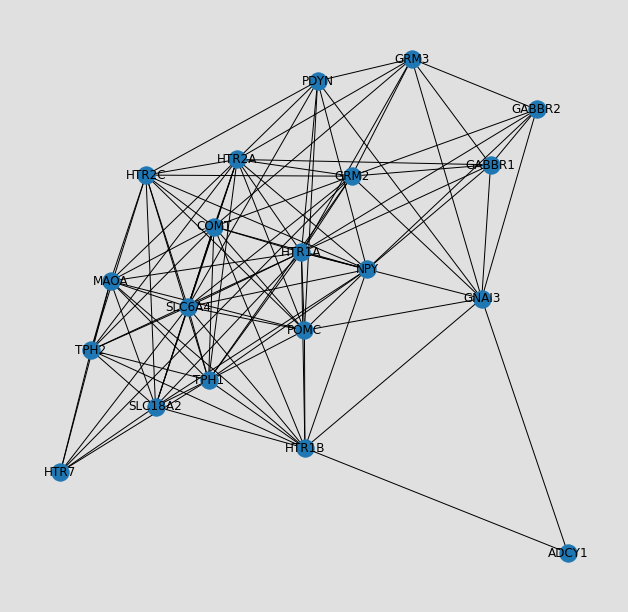

In [5]:
pos = nx.spring_layout(G) # position the nodes using the spring layout
plt.figure(figsize=(11,11),facecolor=[0.7,0.7,0.7,0.4])
nx.draw_networkx(G)
plt.axis('off')
plt.show()

Yukarıda gösterilen basit görselleştirme, graf hakkında daha fazla bilgi içerecek şekilde geliştirilebilir. Bir düğüme bağlı kenarların sayısı olan dereceden daha önce bahsetmiştim. Dahil edebileceğimiz başka bir ölçü, arasındalık (betweenness) merkeziliğidir. Graftaki her düğüm çifti en kısa yoldan bağlanır. Ağırlıksız bir grafikte, en kısa yol, iki düğümü birbirine bağlayan en küçük kenar kümesinden oluşur. Ağırlıklı bir grafta, burada olduğu gibi, en kısa yol, en küçük ağırlık toplamına sahip kenarlar kümesinden oluşur. Belirli bir düğümün arasındalık merkeziliği, tüm en kısa yollardan o düğümden geçen en kısa yolların sayısının ölçüsüdür. Aşağıdaki kod, rengini ve boyutunu belirlemek için her düğümün derece ve arasındalık merkeziliğini kullanır ve kenarların rengini ve boyutunu belirlemek için kenar ağırlıklarını kullanır.

In [6]:
# function to rescale list of values to range [newmin,newmax]
def rescale(l,newmin,newmax):
    arr = list(l)
    return [(x-min(arr))/(max(arr)-min(arr))*(newmax-newmin)+newmin for x in arr]
# use the matplotlib plasma colormap
graph_colormap = cm.get_cmap('plasma', 12)
# node color varies with Degree
c = rescale([G.degree(v) for v in G],0.0,0.9) 
c = [graph_colormap(i) for i in c]
# node size varies with betweeness centrality - map to range [10,100] 
bc = nx.betweenness_centrality(G) # betweeness centrality
s =  rescale([v for v in bc.values()],1500,7000)
# edge width shows 1-weight to convert cost back to strength of interaction 
ew = rescale([float(G[u][v]['weight']) for u,v in G.edges],0.1,4)
# edge color also shows weight
ec = rescale([float(G[u][v]['weight']) for u,v in G.edges],0.1,1)
ec = [graph_colormap(i) for i in ec]

Bu kodla gelişmiş bir görselleştirme oluşturmak için bu renk eşlemelerini kullanabiliriz:

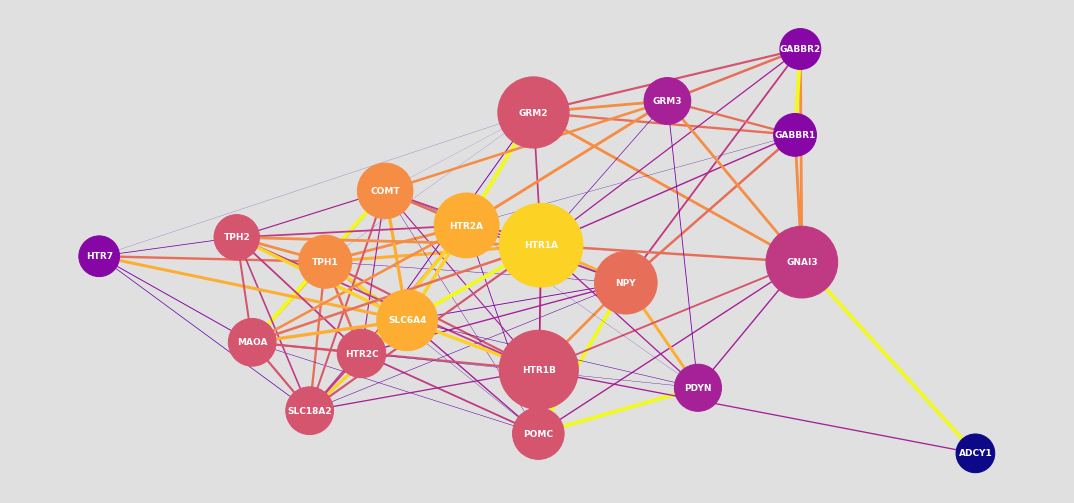

In [7]:
pos = nx.spring_layout(G)
plt.figure(figsize=(19,9),facecolor=[0.7,0.7,0.7,0.4])
nx.draw_networkx(G, pos=pos, with_labels=True, node_color=c, node_size=s,edge_color= ec,width=ew,
                 font_color='white',font_weight='bold',font_size='9')
plt.axis('off')
plt.show()

Bu grafta görüntülenen çok daha fazla bilgi var. Renk aralığı koyu mordan parlak sarıya kadar uzanır. Düğüm ne kadar sarı olursa, derece o kadar yüksek olur. Düğüm ne kadar büyük olursa, arasındalık merkeziliği o kadar büyük olur. Kenar ne kadar sarı ve geniş olursa, etkileşim puanı o kadar yüksek olur.

Son bir kullanışlı görselleştirme, tüm düğümleri mümkün olan en düşük ağırlığa bağlayan kenarların alt kümesi olan minimum yayılan ağaçtır (minimum spanning tree):

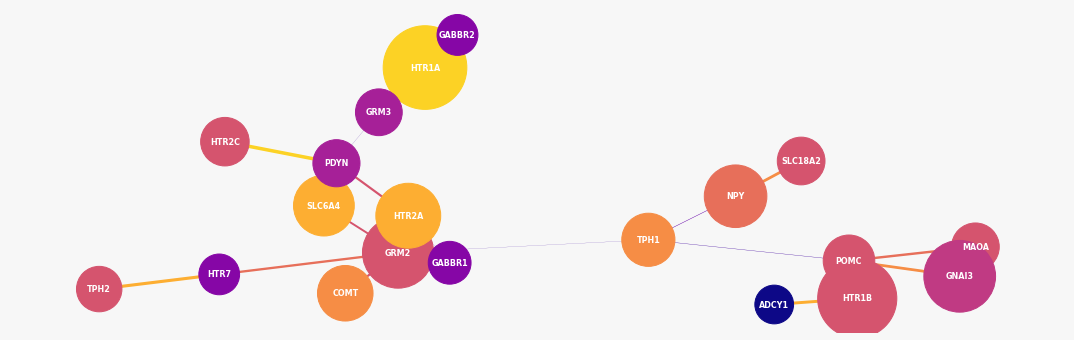

In [9]:
T = nx.minimum_spanning_tree(G)
pos = nx.spring_layout(T)
plt.figure(figsize=(19,6),facecolor=[0.7,0.7,0.7,0.1])
nx.draw_networkx(T, pos=pos, with_labels=True,node_color=c,node_size=s,edge_color= ec,width=ew,
                font_color='white',font_weight='bold',font_size='8')
plt.axis('off')
plt.show()